# Introduction to nonparametric regression

------------------------------------------------------
*Introduction to Data Science & Machine Learning*

*Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------

Today, we will study a different approach to perform regression. In a nutshell, nonparametric models refer to such methods for which the complexity of the underlying model to perform the task (e.g. regression for us) **grows with the number of datapoints we use to train**.

Note that this is in contrast to the linear regression models we have seen before, for which we first had to decide the interpolation function (e.g. a degree-5 polynomial) and then train the model. However, the complexity of the model itself does not vary as we increase the number of points in the dataset. It is always a degree-5 polynomial. This **does not happen with nonparametric models**.

Lets start with a simple method to perform nonparametric regression: [**K-nearest neighbors (K-NN)for regression**](http://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html).

----

## K-NN regression

Consider we have a **training** database of $N$ entries of the form $(\mathbf{x}^{(i)},y^{(i)})$, where $\mathbf{x}^{(i)}\in\mathbb{R}^D$ and $y^{(i)}\in\mathbb{R}$. 

In K-NN regression, given a new point $\mathbf{x}^*$ the estimated target $y^*$ is computed as follows:

\begin{align}
y^* \approx \frac{1}{K}\sum_{k\in \mathcal{S}_{K}(\mathbf{x}^*)} y^{(k)},
\end{align}
where $\mathcal{S}_{K}$ is the set of the **$K$ training points that are closest to $\mathbf{x}^*$ according to a given distance metric $d(\mathbf{x}^{(i)},\mathbf{x}^*)$**. For instance, in real spaces the most common choice is the **ecludean distance**:

\begin{align}
d(\mathbf{x}^{(i)},\mathbf{x}^*) = \left|\left|\mathbf{x}^{(i)}-\mathbf{x}^*\right|\right|^2
\end{align}

There are many variants of the above expression. For instance, we can **weight differently the regression values according to the distance**. In this way, the closest points has a bigger influence in the regression value:

\begin{align}
y^* \approx \frac{1}{K}\sum_{k\in \mathcal{S}_{K}(\mathbf{x}^*)} \frac{d(\mathbf{x}^{(k)},\mathbf{x}^*)}{\sum_{q\in \mathcal{S}_{K}(\mathbf{x}^*)} d(\mathbf{x}^{(q)},\mathbf{x}^*)} y^{(k)},
\end{align}

### K-NN complexity

Note that complexity is determined by the [**search of the set of closest neighbors**](https://en.wikipedia.org/wiki/Nearest_neighbor_search). This complexity grows as $\mathcal{O}(DN)$, where $D$ is the dimension and $N$ is the number of points.

Researches in computer science have developed many approximate lower-complexity algorithms to perform this task in high dimension spaces. The most common ones are [**k-d trees**](https://en.wikipedia.org/wiki/K-d_tree) and [**Local Sensitive Hashing**](https://en.wikipedia.org/wiki/Locality-sensitive_hashing).



### Example of K-NN regression with sklearn

Lets analyze the behavior of K-NN with a simple 1-D regression example.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.kernel_ridge import KernelRidge

%matplotlib inline

# use seaborn plotting defaults
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = [8,8]

In [12]:
np.random.seed(0)

N_train = 50
R = 20
Xtrain = np.sort(np.random.uniform(-R,R,N_train), axis=0)       #Training points

Xtest = np.linspace(-R,R,500)      #Test points

def noise_sinc(X):
    Y = np.sin(X)/np.pi/(X+1e-6) + np.sqrt(1e-04) * np.random.randn(X.shape[0])
    return Y

Ytrain = noise_sinc(Xtrain)
Ytest = noise_sinc(Xtest)

In [13]:
#K-NN training
n_neighbors = 1

knn = neighbors.KNeighborsRegressor(n_neighbors, weights='uniform')
Ypred = knn.fit(Xtrain.reshape([-1,1]), Ytrain.reshape([-1,1])).predict(Xtest.reshape([-1,1]))   #Function .fit does not work with a-dimensional vectors


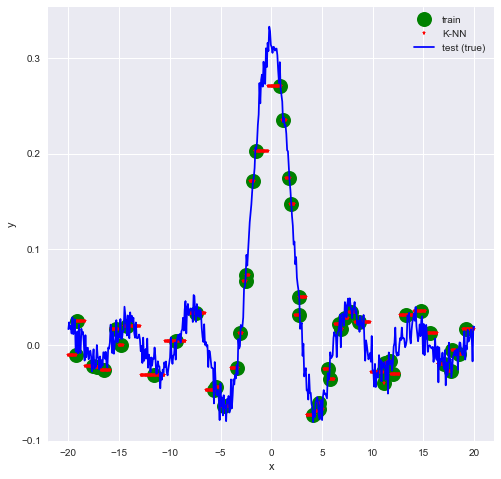

In [14]:
plt.plot(Xtrain,Ytrain,'go',ms=15,label='train')
plt.plot(Xtest,Ypred,'r*',ms=5,label='K-NN')
plt.plot(Xtest,Ytest,'b-',label='test (true)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

### Exercise 

Investigate how does the k-NN regressor behave as you vary either the number of training points and the number of neighbors (K). How do you identify that the model is overfitting? or if the model is too biased? how do you regularize?

## Kernel Linear Regression

Note that the regression function that we learn using a $K$-NN regression is in general non-continuous and non-differentiable at many points. In other words, it is a [**non-smooth function**](http://mathworld.wolfram.com/SmoothFunction.html). Interpolating with smooth functions it is always desirable, as the model will certainly generalize better. 

There are many ways to construct smooth version of a $K$-NN regressor. Now, we will use the most important example: a linear regression based on **kernels**. **Nonparametric models based on kernels constitute a keystone in machine learning**. The following [video](https://www.youtube.com/watch?v=ldzmOuESx5w) is a very clear introduction to kernel machines.

### Ridge linear regression model

Consider we have a **training** database of $N$ entries of the form $(\mathbf{x}^{(i)},y^{(i)})$, where $\mathbf{x}^{(i)}\in\mathbb{R}^L$ and $y^{(i)}\in\mathbb{R}$. 

Imagine that each of the input vectors is transformed to include **additional features** (such as polynomial expansions or any other transformation). We denote the **feature vector** as

\begin{align}
\phi(\mathbf{x}): \mathbb{R}^L \rightarrow \mathbb{R}^D,
\end{align}

where $D\geq L$. Assume that the first element  of $\phi(\mathbf{x})$ is $1$, i.e. $\phi(\mathbf{x})_0=1$, accomodating for the intercept. We will use this training set to fit a model of the form

$$y \approx \theta_0 + \theta_1 \phi(\mathbf{x})_1 + \theta_2 \phi(\mathbf{x})_2 + \ldots + \theta_D \phi(\mathbf{x})_D $$

If we use the **ridge loss function**, i.e.
\begin{align}
L(\boldsymbol{\theta},\lambda) = \frac{1}{N} \left[\sum_{i=1}^{N} (y^{(i)}-\boldsymbol{\theta}^T\phi(\mathbf{x}^{(i)}))^2 + \lambda \sum_{j=1}^{D+1} \theta_j^2\right]
\end{align}
then we know that the minimum is attained at
$$\boldsymbol{\theta}_\lambda = (\mathbf{\Phi}^T\mathbf{\Phi} + \mathbf{D}_\lambda)^{-1}\mathbf{\Phi}^T\mathbf{y},$$
where $\mathbf{\Phi}$ is the $N\times (D+1)$ feature matrix and 
$$ \mathbf{D} = \left[ \begin{array}{cc} 0 & 0 \\ 0 & \lambda \mathbf{I}_{D\times D}\end{array}\right] $$

---


### The kernel-trick and the dual problem representation

Our whole derivation is based upon the following point. If we compute the gradient of $L(\boldsymbol{\theta},\lambda)$ w.r.t. $\boldsymbol{\theta}$ and set it to zero we get

\begin{align}
\boldsymbol{\theta}_\lambda = -\frac{1}{\lambda}\sum_{i=1}^N \left(y^{(i)}-\boldsymbol{\theta}_\lambda^T\phi(\mathbf{x}^{(i)})\right)\phi(\mathbf{x}^{(i)}) = \sum_{i=1}^{N} a^i \phi(\mathbf{x}^{(i)}) = \mathbf{\Phi}^T\mathbf{a},
\end{align}

where $a^i = -\frac{1}{\lambda} \left(y^{(i)}-\boldsymbol{\theta}_\lambda^T\phi(\mathbf{x}^{(i)})\right)$. Thus, the optimal solution belowns to the vector subpspace ** spanned by the feature training vectors**. Note that, given $\mathbf{a}$, the regression estimate for a new vector $\mathbf{x}^{*}$ is:

\begin{align}
y^* \approx \boldsymbol{\theta}_\lambda^T \phi(\mathbf{x}^*) &= \left(\mathbf{\Phi}^T\mathbf{a}\right)^T \phi(\mathbf{x}^*) = \left(\sum_{i=1}^{N} a^i \phi(\mathbf{x}^{(i)})\right)^T \phi(\mathbf{x}^*) = \sum_{i=1}^{N} a^i \phi(\mathbf{x}^{(i)})^T \phi(\mathbf{x}^*) \\ &= \sum_{i=1}^{N} a^i_\lambda k(\mathbf{x}^{(i)},\mathbf{x}^*) = \mathbf{a}^T \mathbf{k}(\mathbf{x}^*), 
\end{align}
where

\begin{align}
\mathbf{k}(\mathbf{x}^*) = \left[\begin{array}{c} k(\mathbf{x}^{(1)},\mathbf{x}^*) \\ k(\mathbf{x}^{(2)},\mathbf{x}^*) \\ \vdots \\ k(\mathbf{x}^{(N)},\mathbf{x}^*)\end{array}\right] = \left[\begin{array}{c} \phi(\mathbf{x}^{(1)})^T \phi(\mathbf{x}^*) \\ \phi(\mathbf{x}^{(2)})^T \phi(\mathbf{x}^*) \\ \vdots \\ \phi(\mathbf{x}^{(N)})^T \phi(\mathbf{x}^*)\end{array}\right] 
\end{align}

and $k(\mathbf{x}^{(i)},\mathbf{x}^*)$ is called the **kernel function** between points $\mathbf{x}^{(i)}$ and $\mathbf{x}^{*}$. In **kernel linear regression**, we will choose a kernel function as **similarity metric** between each pair points and **our goal is to find the vector $\mathbf{a}$ that minimizes the ridge loss function**:

\begin{align}
y^* \approx \sum_{i=1}^{N} a^i k(\mathbf{x}^{(i)},\mathbf{x}^*)
\end{align}

---

### Examples of kernel functions 

In order to explot the kernel trick, we need to be able to construct valid kernel functions. One approach is to choose directly a featre space mapping $\phi(\mathbf{x})$. For instance, if $x\in\mathbb{R}$ we can choose 
\begin{align}
\phi(x) =[1, x, ~ x^2] \Rightarrow  k(x^{(1)},x^{(2)}) = 1+ (x^{(1)}x^{(2)}) + (x^{(1)}x^{(2)})^2
\end{align}

The most common approach is to **choose the kernel directly**. In this case we must ensure that the function we choose ** corresponds to a scalar product in some (perhaps infinite dimensional) feature space** (technicaly, that [Mercer's theorem](http://people.cs.uchicago.edu/~niyogi/papersps/MinNiyYao06.pdf) is satisfied).

Check this [**link**](http://scikit-learn.org/stable/modules/metrics.html) to see possibles examples of kernels that can be used within sklearn. A very common one that actually maps over an **infinite dimensional feature space** is the radial basis function (RBF) or Gaussian kernel:

\begin{align}
k(\mathbf{x},\mathbf{x}^*) = \text{e}^ -\frac{||\mathbf{x}-\mathbf{x}^*||^2}{2\sigma^2},
\end{align}

where $sigma$ is called the bandwith and it is a parameter that typically has to be adjusted by **cross validation**.

**You can understand the kernel as a similarity metric so that the vectors closest to $\mathbf{x}^*$ in the training set are those that weight more in the prediction! (similarly as in K-NN regression but in a smoother fashion).**

---

### Finding the vector of coefficients $\mathbf{a}$

If we substitute $\mathbf{\theta} = \mathbf{\Phi}^T\mathbf{a}$ in the Ridge Loss function we get the dual optimization problem. After some manipulation, the loss function is expressed in the following way:

\begin{align}
L(\boldsymbol{a},\lambda) = \frac{1}{N}\left[\mathbf{a}^T \mathbf{K}^T\mathbf{K}\mathbf{a}-\mathbf{a}^T\mathbf{K}\mathbf{y}+\lambda\mathbf{a}^T\mathbf{K}\mathbf{a}\right],
\end{align}
where $\mathbf{K}$ is the $(N\times N)$ symmetric **kernel matrix** such that

\begin{align}
K_{nm} = k(\mathbf{x}^{(m)},\mathbf{x}^{(n)}).
\end{align}

$L(\boldsymbol{a},\lambda)$ is a convex function whose minimum is attained at

\begin{align}
\boldsymbol{a} = \left(\boldsymbol{K}+\lambda \boldsymbol{I}\right)^{-1} \boldsymbol{y}.
\end{align}

As you probably guess already, this solution is rather approximated by **gradient descent** due to better complexity and stability properties. Also, note that the complexity now increases as $\mathcal{O}(N^3)$ instead of the $\mathcal{O}(D^3)$ complexity that we had in the feature primal space. 

### Example of using kernel ridge linear regression (KRR) for the example above 

We will use [**sklearn implementation of KRR**](http://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html#sklearn.kernel_ridge.KernelRidge)

In [17]:
#K-NN training
clf = KernelRidge(gamma=1,kernel='rbf')   #gamma is the inverse of the bandwith

Ypred = clf.fit(Xtrain.reshape([-1,1]), Ytrain.reshape([-1,1])).predict(Xtest.reshape([-1,1]))   #Function .fit does not work with a-dimensional vectors



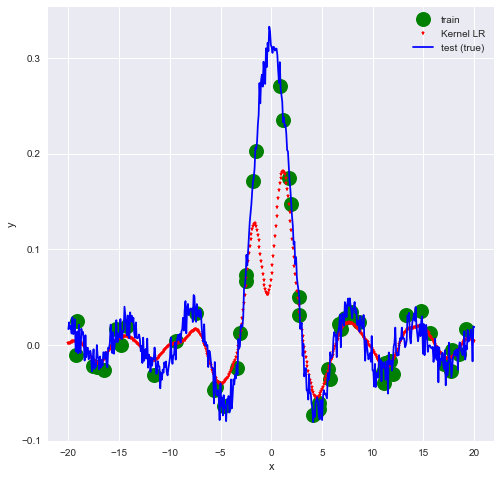

In [18]:
plt.plot(Xtrain,Ytrain,'go',ms=15,label='train')
plt.plot(Xtest,Ypred,'r*',ms=5,label='Kernel LR')
plt.plot(Xtest,Ytest,'b-',label='test (true)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

### Exercise 

Investigate how does the kernel regressor behave as you vary either the number of training points and the bandwith in the RBF kernel. How do you identify that the model is overfitting? or if the model is too biased? how do you regularize?

Investigate also the effect of varying the kernel.